# Домашнее задание №2. SVM.

Нужно реализовать несколько алгоритмов SVM с помощью numpy/scipy библиотек. Каждую из реализаций сравнить с соответсвующей sklearn реализацией SVM алгоритма. 

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, make_scorer
from scipy.spatial.distance import cdist
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from scipy.optimize import minimize
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from matplotlib import pyplot as plt
from mlxtend.plotting import plot_decision_regions
from IPython.display import clear_output
from itertools import combinations

## Задание №1 (15 баллов)

Реализовать класс **LinearPrimalSVM** - метод решения **много-классового линейного метода опорных векторов в стандартной задаче  оптимизации с квадратичной регуляризацией**. Для обучения много-классового алгоритма воспользоваться схемой **one-vs-rest**.  Реализовать методы init, fit, predict c возможностью конфигурации параметра регуляризации. Остальные функции реализовать на ваше усмотрение. 

Для оптимизации функции ошибки воспользоваться методом **стохастического градиентного спуска**.

In [107]:
X = np.array([]).reshape(0, 2)
y = np.array([])
vectors = ([4, 4], [-1.5, 2], [1.5, 0.5], [-2.5, -2])

for i in range(4):
    x_tmp = np.ones(1000).reshape(-1, 2)
    x_tmp *= vectors[i]
    x_tmp += np.random.normal(size=x_tmp.shape)
    print(x_tmp.shape)
    X = np.vstack((X, x_tmp))
    y = np.append(y, np.ones(x_tmp.shape[0])*i)
y = y.astype(int)

(500, 2)
(500, 2)
(500, 2)
(500, 2)


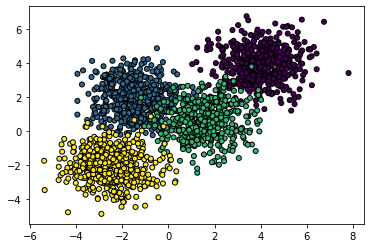

In [108]:
plt.scatter(X[:, 0], X[:, 1], marker="o", c=y, s=25, edgecolor="k")
plt.show()

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [110]:
class LinearPrimalSVM:
    def __init__(self, C, penalty, lr, epochs=1000):
        self.C = C
        self.penalty = penalty
        self.lr = lr
        self.epochs = epochs

    def loss_function(self, X, y, w, w0):
      M = (X @ w + w0) * y
      M = np.clip(1 - M, 0, None)
      loss = np.sum(M) / np.sum(M != 0)
      if self.penalty == 'l2':
        loss += self.C * np.sum(w**2)
      return loss

    def grad(self, X, y, w, w0):
      M = (X @ w + w0) * y
      M = np.clip(1 - M, 0, None)
      grad_w = -1/y.shape[0] * np.sum(X[M > 0] * y[M > 0].reshape(-1, 1), axis=0)
      grad_w0 = -1/y.shape[0] * np.sum(y[M > 0].reshape(-1, 1))
      if self.penalty == "l2":
        grad_w += 2*self.C * w
      return grad_w, grad_w0

    def fit(self, X, y):
        """функция обучения модели"""
        def fit_binary_classification(X, y):
          """SVM для бинарной классификации, нужен так как решаем задачу one-vs-rest"""
          w = np.random.randn(X.shape[1])
          w0 = np.random.randn()
          for i in range(self.epochs):
            grad_w, grad_w0 = self.grad(X, y, w, w0)
            w -= self.lr * grad_w
            w0 -= self.lr * grad_w0
          return np.append(w, w0)

        self.classes = np.unique(y)
        all_weights = []
        for mark in self.classes:
          y_ = (y == mark).astype(int)
          y_[y_ == 0] = -1
          weights = fit_binary_classification(X, y_)
          all_weights.append(weights)

        all_weights = np.array(all_weights)
        self.w = all_weights[:, :-1]
        self.w0 = all_weights[:, -1]
        return all_weights
    
    def predict(self, X):
        """функция предсказания"""
        M = X @ self.w.T + self.w0.reshape(1, -1)
        return self.classes[np.argmax(M, axis=1)]

In [118]:
my_model = LinearPrimalSVM(penalty='l2', lr=3e-2, C=1e-3, epochs=10000)
my_model_weights = my_model.fit(X_train, y_train)
my_y_pred = my_model.predict(X_test)
my_accuracy = accuracy_score(my_y_pred, y_test)

sklearn_model = SGDClassifier(
    loss='hinge', 
    penalty='l2', 
    fit_intercept=True
    )
sklearn_model.fit(X_train, y_train)
sklearn_y_pred = sklearn_model.predict(X_test)
sklearn_accuracy = accuracy_score(sklearn_y_pred, y_test)

print("Точность написанной модели : {}".format(my_accuracy))
print("Точность модели Sklearn: {}".format(sklearn_accuracy))
print("Процент отличия : {:.2%}".format(abs(my_accuracy-sklearn_accuracy)))

Точность написанной модели : 0.9333333333333333
Точность модели Sklearn: 0.9363636363636364
Процент отличия : 0.30%


Оцените ваш алгоритм на тестовом сплите многоклассовом датасете классификации по выбранной метрике качества. Датасеты для классификации можно взять например [**отсюда**](https://archive.ics.uci.edu/ml/datasets.php?format=&task=cla&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table) или сгенерировать самому. Сравните ваш алгоритм с sklearn имплементацией со следующими парарметрами:

[*_sklearn.linear_model.SGDClassifier(loss='hinge', penalty='l2', fit_intercept=True)_*](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)

Остальные параметры алгоритма на ваше усмотрение. 

Отличие в метриках между вашим алгоритмом и sklearn имплементацией алгоритма. Отличие в качестве не должно составлять более **1-2%**.

### Задание № 2 (10 баллов)

Визуализируйте построенные разделяющие прямые на вашем мультиклассовом датасете. Для визуализации можно пользоваться любыми библиотеками визуализации. В конце ноутбука приведены вспомогательные функции для визуализации.

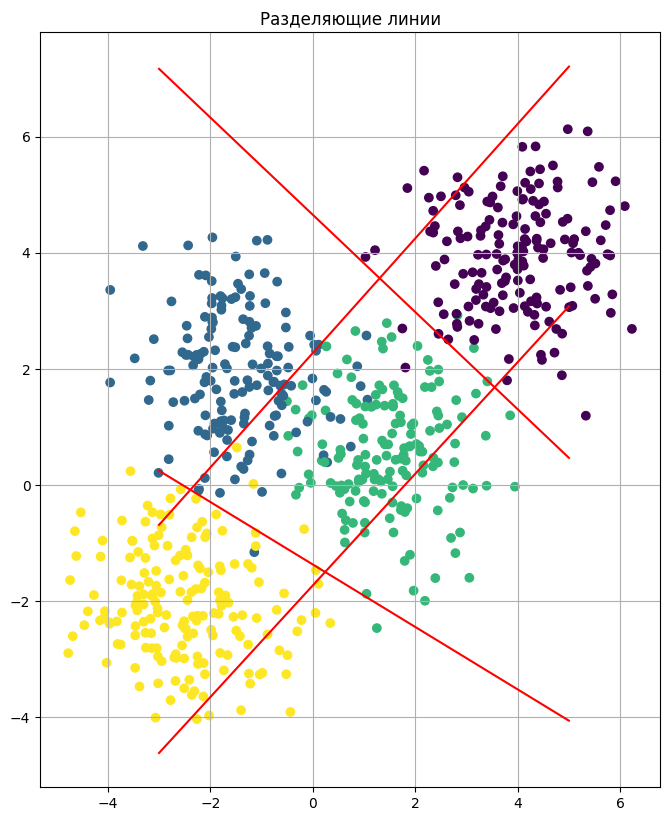

In [120]:
def plot_separating_lines(plt, x, weights):
  a, b = weights[0] / weights[1], weights[2]/weights[1]
  y = -a * x - b
  plt.plot(x, y, c="red", linestyle="-")

plt.figure(figsize=(8, 10), dpi=100)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test)
for weights in my_model_weights:
  plot_separating_lines(plt, np.linspace(-3,5,100), weights)
plt.title("Разделяющие линии")
plt.grid()
plt.show()

Постройте график зависимости качества вашего алгоритма от параметра регуляризации на тестовом сплите. 

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


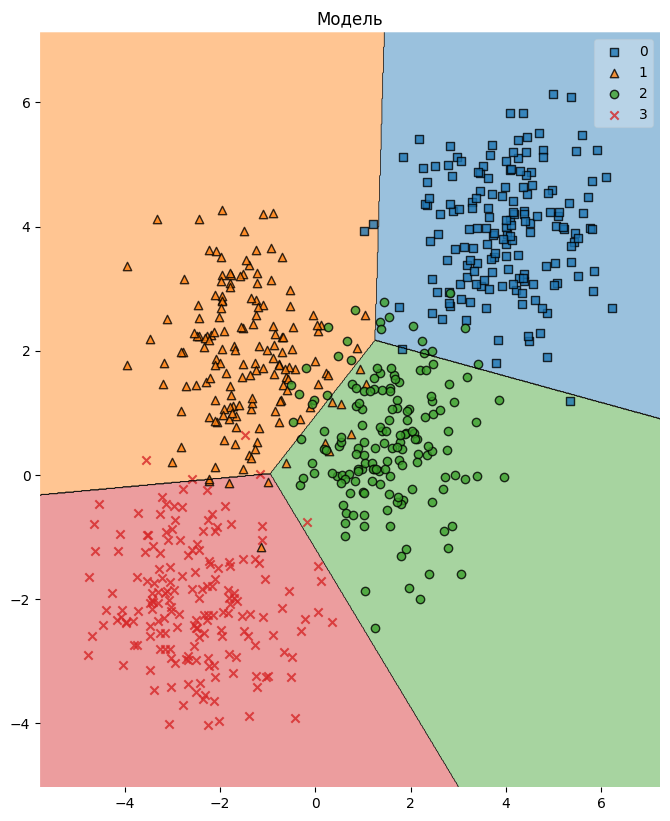

In [121]:
plt.figure(figsize=(8, 10), dpi=100)
plot_decision_regions(X_test, y_test, my_model)
plt.title("Модель")
plt.show()

In [125]:
reg_params = np.logspace(-10, 5, 16)
print(reg_params)

[1.e-10 1.e-09 1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01
 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05]


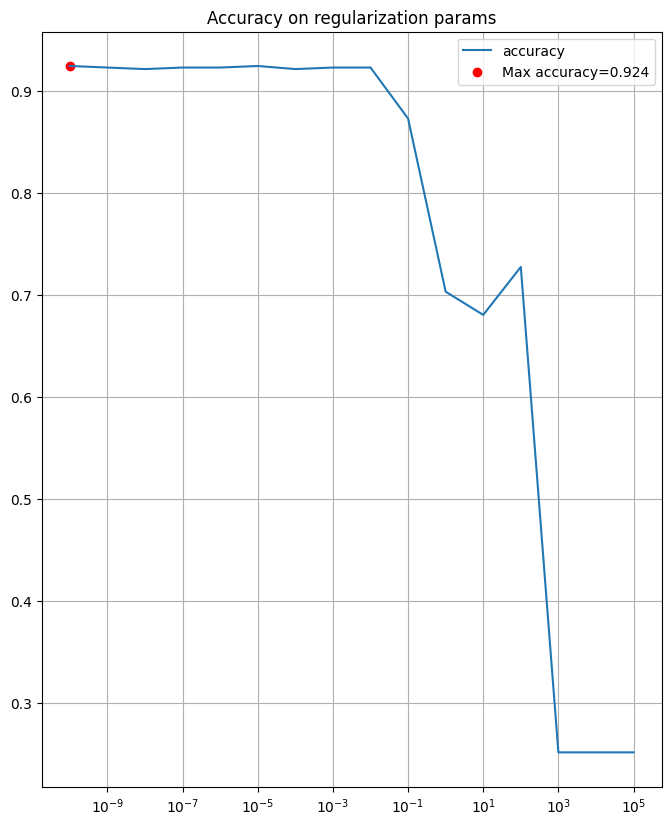

In [126]:
accuracies = []
for C in reg_params:
  my_model = LinearPrimalSVM(
      penalty='l2', 
      lr=3e-3, 
      C=C, 
      epochs=10000
  )

  my_model_weights = my_model.fit(X_train, y_train)
  my_y_pred = my_model.predict(X_test)
  my_accuracy = accuracy_score(my_y_pred, y_test)
  accuracies.append(my_accuracy)
clear_output()

argmax = np.argmax(accuracies)
plt.figure(figsize=(8, 10), dpi=100)
plt.plot(reg_params, accuracies, label="accuracy")
plt.scatter(reg_params[argmax], accuracies[argmax], c='r', label=f"Max accuracy={round(accuracies[argmax], 3)}")
plt.title("Accuracy on regularization params")
plt.xscale('log')
plt.grid()
plt.legend()
plt.show()

### Задание №3 (10 баллов)

Реализовать **NonlinearDualSVM** - метод решения **много-классового нелинейного метода опорных векторов двойственной задаче  оптимизации с квадратичной регуляризацией с поддежкой любого нелинейного ядра**. Алгоритм решения SVM через двойственную задачу можно взять из ноутбука, который мы рассматривали в классе - вам нужно поддержать многоклассовое решение задачи и поддержку ядра для решений в нелинейном случае. 

Для обучения много-классового алгоритма воспользоваться схемой **one-vs-one**. В качестве нелинейного ядра можно взять любое нелинейное [отсюда](https://scikit-learn.org/stable/modules/svm.html#svm-kernels).

**Подсказка**

Получить получить ядерную матрицу Грамма можно так:

```python 
# X shape is (N, dim)
# y_hat shape is (N, 1)

def kernel(x1, x2):
    return np.dot(x1, x2)

kernalized_X = np.apply_along_axis(lambda x1 : np.apply_along_axis(lambda x2: kernel(x1, x2), 1, X), 1, X)  
gram_matrix_Xy = kernalized_X * np.matmul(y_hat, y_hat.T) 
```

In [ ]:
class NonlinearDualSVM:
    def __init__(self, regularization_type):
        self.regularization_type = regularization_type
    
    def fit():
        """функция обучения модели"""
        # CODE HERE
        pass
    
    def predict():
        """функция предсказания"""
        # CODE HERE
        pass

Оцените ваш алгоритм на тестовом сплите многоклассовом датасете классификации по выбранной метрике качества. Датасеты для классификации можно взять например [**отсюда**](https://archive.ics.uci.edu/ml/datasets.php?format=&task=cla&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table) или сгенерировать самому. Сравните ваш алгоритм с sklearn имплементацией со следующими параметрами:

[*_class sklearn.svm.SVC(kernel='poly/rbf/sigmoid')_*](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)

Остальные параметры алгоритма на ваше усмотрение либо при необходимости для выбранного ядра. 

Отличие в метриках между вашим алгоритмом и sklearn имплементацией алгоритма не должно составлять более **5%**.

In [ ]:
#CODE HERE

#### Вспомогательные функции визуализации

Данные для линейного/нелинейного разделения можно сгенерировать самому используя функции для визуализации.

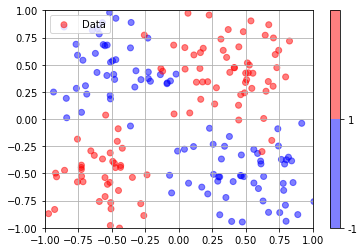

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
import numpy as np

def plot_line(ax, x_range, w, x0, label, color='grey', linestyle='-', alpha=1.):
    """График разделяющей прямой с помощью вектора весов w и смещения x0"""
    if type(x0) == int or type(x0) == float or type(x0) == np.float64:
        x0 = [0, -x0 / w[1]]
    yy = -(w[0] / w[1]) * (x_range - x0[0]) + x0[1]
    ax.plot(x_range, yy, color=color, label=label, linestyle=linestyle)
    
def plot_svm(X, y, support=None, w=None, intercept=0., label='Data', separatorLabel='Separator', 
            ax=None, bound=[[-1., 1.], [-1., 1.]]):
    """График SVM оптимальной разделяющей прямой c отображением опорных векторов support
    вектора весов w и смещения intercept"""
    if ax is None:
        fig, ax = plt.subplots(1)
    
    im = ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap, alpha=0.5, label=label)
    if support is not None:
        ax.scatter(support[:,0], support[:,1], label='Support', s=80, facecolors='none', 
                   edgecolors='y', color='y')
        print("Количество опорных векторов = %d" % (len(support)))
    if w is not None:
        xx = np.array(bound[0])
        plot_line(ax, xx, w, intercept, separatorLabel)
        # Plot margin
        if support is not None:
            signed_dist = np.matmul(support, w)
            margin = np.max(signed_dist) - np.min(signed_dist) * np.sqrt(np.dot(w, w))
            support_max_neg = support[np.argmin(signed_dist)]
            plot_line(ax, xx, w, support_max_neg, 'Margin -', linestyle='-.', alpha=0.8)
            support_max_pos = support[np.argmax(signed_dist)]
            plot_line(ax, xx, w, support_max_pos, 'Margin +', linestyle='--', alpha=0.8)
            ax.set_title('Margin = %.3f' % (margin))
    ax.legend(loc='upper left')
    ax.grid()
    ax.set_xlim(bound[0])
    ax.set_ylim(bound[1])
    cb = plt.colorbar(im, ax=ax)
    loc = np.arange(-1,1,1)
    cb.set_ticks(loc)
    cb.set_ticklabels(['-1','1'])


def generate_batch_xor(n, mu=0.5, sigma=0.5):
    """ гауссианы в форме XOR операции"""
    X = np.random.normal(mu, sigma, (n, 2))
    yB0 = np.random.uniform(0, 1, n) > 0.5
    yB1 = np.random.uniform(0, 1, n) > 0.5
    # y is in {-1, 1}
    y0 = 2. * yB0 - 1
    y1 = 2. * yB1 - 1
    X[:,0] *= y0
    X[:,1] *= y1
    X -= X.mean(axis=0)
    return X, y0*y1

colors = ['blue','red']
cmap = pltcolors.ListedColormap(colors)
nFeatures = 2
N = 100
xTrain3, yTrain3 = generate_batch_xor(2*N, sigma=0.25)
plot_svm(xTrain3, yTrain3)
xTest3, yTest3 = generate_batch_xor(2*N, sigma=0.25)